In [1]:
from CosinorPy import file_parser, cosinor, cosinor1
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy
import matplotlib.patches as mpatches
from venn import venn
import statsmodels.stats
%matplotlib inline

In [2]:
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'svg.fonttype': 'none'
})
sns.set(style='whitegrid')

In [3]:
metadata = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/metadata_all_col.csv', low_memory = False, index_col = "sample_id")
asv = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/asv.csv', index_col = 'Unnamed: 0', low_memory = False)
genus =pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/genus.csv', index_col = 'Unnamed: 0', low_memory = False)

In [4]:
def fcosinor(joint_file):
    joint_file = joint_file.astype(float)
    melted = pd.melt(joint_file, id_vars='col_bin', var_name='test', value_name='y')
    melted['x'] = melted['col_bin']
    cosinor_results = cosinor1.fit_group(melted, period=[24], plot_on=False).sort_values(by='q')
    print(cosinor_results['q'].lt(0.05).sum())
    return cosinor_results

In [5]:
#consolidating city labels
metadata['city'] = metadata['city'].replace(
    to_replace={r'Boston\.\d': 'Boston', r'San Diego\.\d': 'San Diego'},
    regex=True
)

In [6]:
#Creating regions of interest
uk = metadata[metadata.country =='United Kingdom']
usa = metadata[metadata.country =='USA']
cal  = metadata[metadata.state == 'USA:CA']

cal['latitude_n'] = pd.to_numeric(cal['latitude'], errors='coerce')
socal = cal[(cal['latitude_n'] <35.5) & (cal['latitude_n'] >32.536)] #cutoffs are kinda arbitrary but good enough

northeast_states = ['USA:MA', 'USA:NY', 'USA:NJ', 'USA:ME', 'USA:CT', 'USA:NH', 'USA:VT', 'USA:PA', 'USA:MD', 'USA:DE', 'USA:DC']
ne = metadata[metadata['state'].isin(northeast_states)]

/tmp/ipykernel_147257/753222903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['latitude_n'] = pd.to_numeric(cal['latitude'], errors='coerce')


In [7]:
# subsetting
def process_data(genus, region, filename):
    region_genus = genus[genus.index.isin(region.index)]
    region_genus_j = region_genus.join(region.col_bin).dropna()
    region_cosinor = fcosinor(region_genus_j)
    region_cosinor.to_csv(filename)
    return region_cosinor

In [8]:
regions = {'UK': uk, 'California': cal, 'New England': ne}
filenames = {
    'UK': '/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/uk_genus.csv',
    'California': '/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/california_genus.csv',
    'New England': '/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/new_england_genus.csv'
}

region_cosinors = {}
for region_name, region in regions.items():
    region_cosinor = process_data(genus, region, filenames[region_name])
    region_cosinors[region_name] = region_cosinor

10
0
21


In [9]:
# Filter significant results
significant_results = {}
for region_name, region_cosinor in region_cosinors.items():
    significant = region_cosinor[region_cosinor.q < 0.05].set_index('test')
    significant = significant.rename(columns={'acrophase[h]': 'Acrophase'})
    significant_results[region_name] = significant

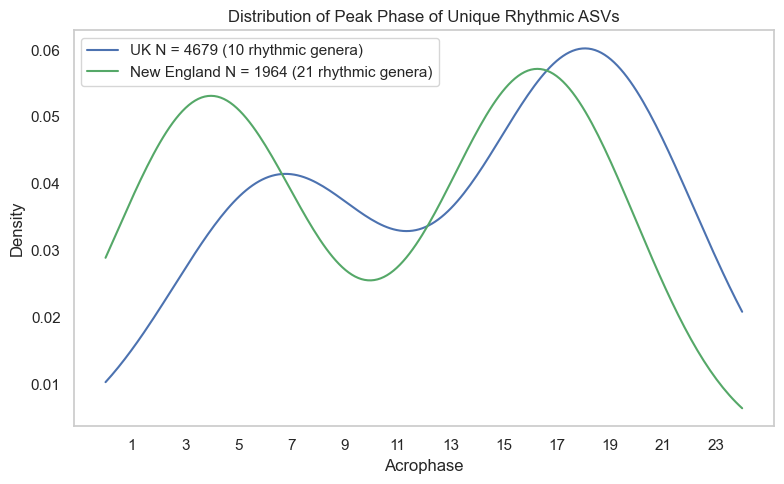

In [12]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 5))
for region_name, significant in significant_results.items():
    sns.kdeplot(data=significant, x='Acrophase', clip=(0.0, 24), label=f'{region_name} N = {len(regions[region_name])} ({len(significant)} rhythmic genera)', warn_singular = False)

ax.set_xlabel('Acrophase')
ax.set_ylabel('Density')
ax.set_title('Distribution of Peak Phase of Unique Rhythmic ASVs') 
ax.legend()
ax.grid(False)
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23])
plt.tight_layout()  
plt.savefig('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/figures/uk_northeast_density.png', dpi=600, bbox_inches='tight')